# Preprocessing steps for face alignment and cropping

In [1]:
import face_alignment
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import collections
import numpy as np
import dlib
import cv2
from imutils import face_utils
import imutils
import os

In [2]:
def get_box(a, w, h):
    xav = int(np.average(a[:, 0]))
    yav = int(np.average(a[:, 1]))

    xmin = xav - (w // 2)
    ymin = yav - (h // 2)
    
    return xmin, ymin

In [3]:
file_pre = 'flipped/00001_1'

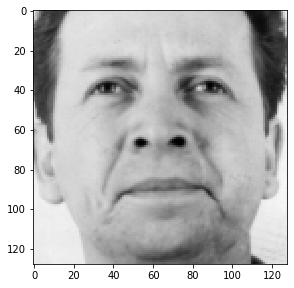

In [4]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
image = dlib.load_rgb_image(file_pre + '_F.png')
#image = imutils.resize(image, width=128)
dets = detector(image, 1)
faces = dlib.full_object_detections()
for detection in dets:
    faces.append(sp(image, detection))
image = dlib.get_face_chip(image, faces[0], size=128)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image, cmap='gray')

In [5]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cuda')
preds = fa.get_landmarks(image)[-1]

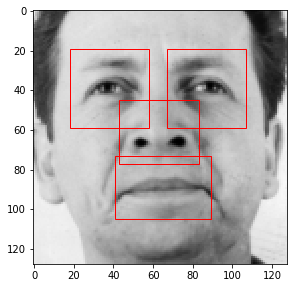

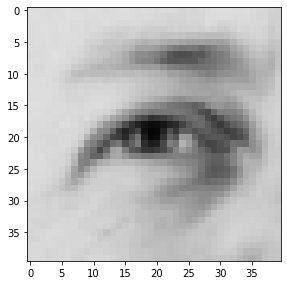

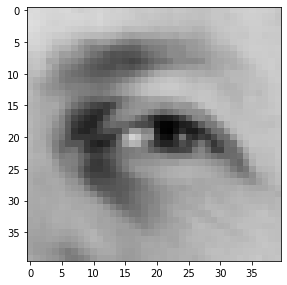

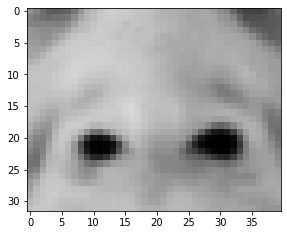

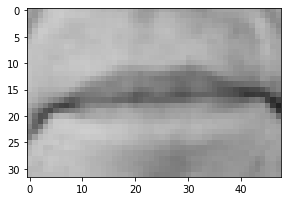

In [6]:
eye1_x, eye1_y = get_box(preds[36:42, :], 40, 40)
eye1_rect = patches.Rectangle((eye1_x, eye1_y), 40, 40, linewidth=1, edgecolor='r', facecolor='none')
eye1_im = image[eye1_y:eye1_y+40, eye1_x:eye1_x+40]

eye2_x, eye2_y = get_box(preds[42:48, :], 40, 40)
eye2_rect = patches.Rectangle((eye2_x, eye2_y), 40, 40, linewidth=1, edgecolor='r', facecolor='none')
eye2_im = image[eye2_y:eye2_y+40, eye2_x:eye2_x+40]

nose_x, nose_y = get_box(preds[27:36, :], 40, 32)
nose_rect = patches.Rectangle((nose_x, nose_y), 40, 32, linewidth=1, edgecolor='r', facecolor='none')
nose_im = image[nose_y:nose_y+32, nose_x:nose_x+40]

mouth_x, mouth_y = get_box(preds[48:60, :], 48, 32)
mouth_rect = patches.Rectangle((mouth_x, mouth_y), 48, 32, linewidth=1, edgecolor='r', facecolor='none')
mouth_im = image[mouth_y:mouth_y+32, mouth_x:mouth_x+48]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image, cmap='gray')
ax.add_patch(eye1_rect)
ax.add_patch(eye2_rect)
ax.add_patch(nose_rect)
ax.add_patch(mouth_rect)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(eye1_im, cmap='gray')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(eye2_im, cmap='gray')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(nose_im, cmap='gray')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(mouth_im, cmap='gray')

(460, 896, 3)


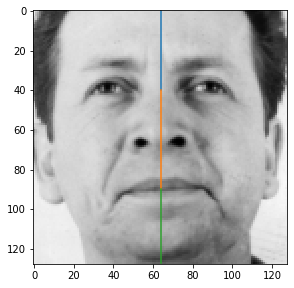

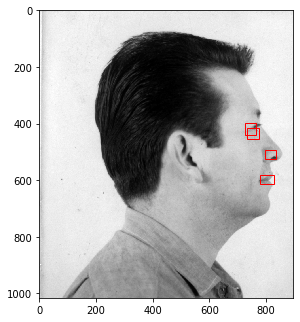

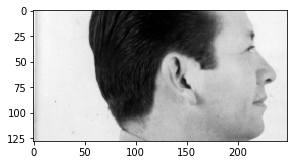

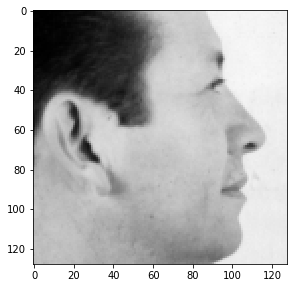

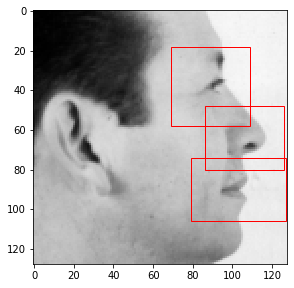

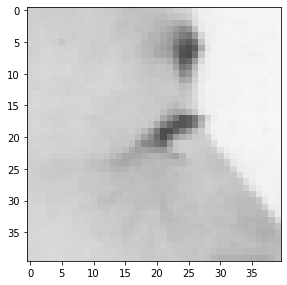

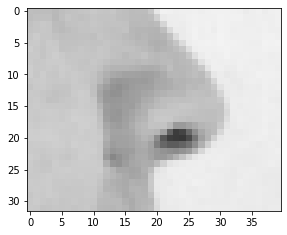

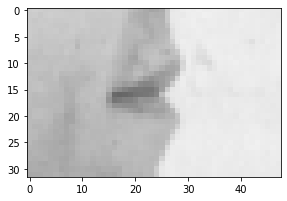

In [7]:
top_to_eye = np.average(preds[36:42, 1])
mouth_to_bottom = 128 - np.average(preds[48:60, 1])
eye_to_mouth = 128 - top_to_eye - mouth_to_bottom

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image, cmap='gray')
ax.plot([64, 64], [0, top_to_eye])
ax.plot([64, 64], [top_to_eye, top_to_eye + eye_to_mouth])
ax.plot([64, 64], [top_to_eye + eye_to_mouth, 127])

image_p = dlib.load_rgb_image(file_pre + '_R.png')
preds_p = fa.get_landmarks(image_p)[-1]
eye_to_mouth_p = np.average(preds_p[48:60, 1]) - np.average(preds_p[36:42, 1])

###
eye1_x_q, eye1_y_q = get_box(preds_p[36:42, :], 40, 40)
eye1_rect_q = patches.Rectangle((eye1_x_q, eye1_y_q), 40, 40, linewidth=1, edgecolor='r', facecolor='none')

eye2_x_q, eye2_y_q = get_box(preds_p[42:48, :], 40, 40)
eye2_rect_q = patches.Rectangle((eye2_x_q, eye2_y_q), 40, 40, linewidth=1, edgecolor='r', facecolor='none')

nose_x_q, nose_y_q = get_box(preds_p[27:36, :], 40, 32)
nose_rect_q = patches.Rectangle((nose_x_q, nose_y_q), 40, 32, linewidth=1, edgecolor='r', facecolor='none')

mouth_x_q, mouth_y_q = get_box(preds_p[48:60, :], 48, 32)
mouth_rect_q = patches.Rectangle((mouth_x_q, mouth_y_q), 48, 32, linewidth=1, edgecolor='r', facecolor='none')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image_p, cmap='gray')
ax.add_patch(eye1_rect_q)
ax.add_patch(eye2_rect_q)
ax.add_patch(nose_rect_q)
ax.add_patch(mouth_rect_q)
###

factor = eye_to_mouth_p /  eye_to_mouth
top = int(np.average(preds_p[36:42, 1]) - (top_to_eye * factor))
bottom = int(np.average(preds_p[48:60, 1]) + (mouth_to_bottom * factor))

image_p = image_p[top:bottom, :]
print(image_p.shape)

image_p = imutils.resize(image_p, height=128)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image_p, cmap='gray')

###########
preds_p = fa.get_landmarks(image_p)[-1]

nose_tip = int(np.average(preds_p[27:36, 0])) +  20 + 5
mouth_tip = int(np.average(preds_p[48:60, :])) +  24 + 5
front = max(nose_tip, mouth_tip)
if  front > image_p.shape[1]:
    front = image_p.shape[1]
back_head = front - 128
if back_head < 0:
    back_head = 0
    front = 128

image_p = image_p[:, back_head:front]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image_p, cmap='gray')

#preds_p = fa.get_landmarks(image_p)[-1]
preds_p[:, 0] -= back_head

eye1_x, eye1_y = get_box(preds_p[36:42, :], 40, 40)
eye1_rect = patches.Rectangle((eye1_x, eye1_y), 40, 40, linewidth=1, edgecolor='r', facecolor='none')
eye1_im_p = image_p[eye1_y:eye1_y+40, eye1_x:eye1_x+40]

nose_x, nose_y = get_box(preds_p[27:36, :], 40, 32)
nose_rect = patches.Rectangle((nose_x, nose_y), 40, 32, linewidth=1, edgecolor='r', facecolor='none')
nose_im_p = image_p[nose_y:nose_y+32, nose_x:nose_x+40]
if nose_im_p.shape[1] < 40:
    pad = 40 - nose_im_p.shape[1]
    nose_im_p = np.concatenate((nose_im_p, np.zeros((32, pad, 3), dtype=np.int32)), axis=1)

mouth_x, mouth_y = get_box(preds_p[48:60, :], 48, 32)
mouth_rect = patches.Rectangle((mouth_x, mouth_y), 48, 32, linewidth=1, edgecolor='r', facecolor='none')
mouth_im_p = image_p[mouth_y:mouth_y+32, mouth_x:mouth_x+48]
if mouth_im_p.shape[1] < 48:
    pad = 48 - mouth_im_p.shape[1]
    mouth_im_p = np.concatenate((mouth_im_p, np.zeros((32, pad, 3), dtype=np.int32)), axis=1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image_p, cmap='gray')
ax.add_patch(eye1_rect)
ax.add_patch(nose_rect)
ax.add_patch(mouth_rect)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(eye1_im_p, cmap='gray')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(nose_im_p, cmap='gray')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(mouth_im_p, cmap='gray')


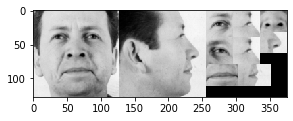

In [8]:
face_data = np.concatenate((image, image_p), axis = 1)

eye1_data = np.concatenate((eye1_im, eye1_im_p), axis = 1)
eye2_data = np.concatenate((eye2_im, eye1_im_p), axis = 1)
eye_data = np.concatenate((eye1_data, eye2_data), axis = 0)

nose_data = np.concatenate((nose_im, nose_im_p), axis = 0)
nose_data = np.concatenate((nose_data, np.zeros((16,40,3),dtype=np.int32)), axis = 0)

eye_nose_data = np.concatenate((eye_data, nose_data), axis = 1)

mouth_data = np.concatenate((mouth_im, mouth_im_p), axis = 1)
mouth_data = np.concatenate((mouth_data, np.zeros((32,24,3),dtype=np.int32)), axis = 1)

total_data = np.concatenate((eye_nose_data, mouth_data), axis = 0)
total_data = np.concatenate((total_data, np.zeros((16,120,3),dtype=np.int32)), axis = 0)
total_data = np.concatenate((face_data, total_data), axis = 1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(total_data, cmap='gray')

In [9]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def generate(folder, file_pre):
    image = dlib.load_rgb_image(folder + '/' + file_pre + '_F.png')
    dets = detector(image, 1)
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(image, detection))
    image = dlib.get_face_chip(image, faces[0], size=128)
    
    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cuda')
    preds = fa.get_landmarks(image)[-1]
    
    eye1_x, eye1_y = get_box(preds[36:42, :], 40, 40)
    eye1_im = image[eye1_y:eye1_y+40, eye1_x:eye1_x+40]

    eye2_x, eye2_y = get_box(preds[42:48, :], 40, 40)
    eye2_im = image[eye2_y:eye2_y+40, eye2_x:eye2_x+40]

    nose_x, nose_y = get_box(preds[27:36, :], 40, 32)
    nose_im = image[nose_y:nose_y+32, nose_x:nose_x+40]

    mouth_x, mouth_y = get_box(preds[48:60, :], 48, 32)
    mouth_im = image[mouth_y:mouth_y+32, mouth_x:mouth_x+48]
    
    # Profile
    top_to_eye = np.average(preds[36:42, 1])
    mouth_to_bottom = 128 - np.average(preds[48:60, 1])
    eye_to_mouth = 128 - top_to_eye - mouth_to_bottom

    image_p = dlib.load_rgb_image(folder + '/' + file_pre + '_R.png')
    preds_p = fa.get_landmarks(image_p)[-1]
    eye_to_mouth_p = np.average(preds_p[48:60, 1]) - np.average(preds_p[36:42, 1])

    factor = eye_to_mouth_p /  eye_to_mouth
    top = int(np.average(preds_p[36:42, 1]) - (top_to_eye * factor))
    bottom = int(np.average(preds_p[48:60, 1]) + (mouth_to_bottom * factor))

    image_p = image_p[top:bottom, :]

    image_p = imutils.resize(image_p, height=128)

    ###########
    preds_p = fa.get_landmarks(image_p)[-1]

    nose_tip = int(np.average(preds_p[27:36, 0])) +  20 + 5
    mouth_tip = int(np.average(preds_p[48:60, :])) +  24 + 5
    front = max(nose_tip, mouth_tip)
    if  front > image_p.shape[1]:
        front = image_p.shape[1]
    back_head = front - 128
    if back_head < 0:
        back_head = 0
        front = 128

    image_p = image_p[:, back_head:front]

    preds_p[:, 0] -= back_head

    eye1_x, eye1_y = get_box(preds_p[36:42, :], 40, 40)
    eye1_im_p = image_p[eye1_y:eye1_y+40, eye1_x:eye1_x+40]

    nose_x, nose_y = get_box(preds_p[27:36, :], 40, 32)
    nose_im_p = image_p[nose_y:nose_y+32, nose_x:nose_x+40]
    if nose_im_p.shape[1] < 40:
        pad = 40 - nose_im_p.shape[1]
        nose_im_p = np.concatenate((nose_im_p, np.zeros((32, pad, 3), dtype=np.int32)), axis=1)

    mouth_x, mouth_y = get_box(preds_p[48:60, :], 48, 32)
    mouth_im_p = image_p[mouth_y:mouth_y+32, mouth_x:mouth_x+48]
    if mouth_im_p.shape[1] < 48:
        pad = 48 - mouth_im_p.shape[1]
        mouth_im_p = np.concatenate((mouth_im_p, np.zeros((32, pad, 3), dtype=np.int32)), axis=1)
    
    # Combine
    face_data = np.concatenate((image, image_p), axis = 1)

    eye1_data = np.concatenate((eye1_im, eye1_im_p), axis = 1)
    eye2_data = np.concatenate((eye2_im, eye1_im_p), axis = 1)
    eye_data = np.concatenate((eye1_data, eye2_data), axis = 0)

    nose_data = np.concatenate((nose_im, nose_im_p), axis = 0)
    nose_data = np.concatenate((nose_data, np.zeros((16,40,3),dtype=np.int32)), axis = 0)

    eye_nose_data = np.concatenate((eye_data, nose_data), axis = 1)

    mouth_data = np.concatenate((mouth_im, mouth_im_p), axis = 1)
    mouth_data = np.concatenate((mouth_data, np.zeros((32,24,3),dtype=np.int32)), axis = 1)

    total_data = np.concatenate((eye_nose_data, mouth_data), axis = 0)
    total_data = np.concatenate((total_data, np.zeros((16,120,3),dtype=np.int32)), axis = 0)
    total_data = np.concatenate((face_data, total_data), axis = 1)
    cv2.imwrite('gen/' + file_pre + '.png', total_data)

In [ ]:
for i in range(1, 1349):
    for j in range(1,4):
        file_pre = str(i).zfill(5)
        fname = 'flipped/' +  file_pre + '_' + str(j) + '_F.png'
        if os.path.isfile(fname):
            file_pre2 = file_pre + '_' + str(j)
            try:
                generate('flipped', file_pre2)
            except:
                print(file_pre2)